In [1]:
# Data stuff
import numpy as np
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
# Configs 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Random state seed
rand_state=42

# ML stuff
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap

# Dask
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

# Imbalanced learn 
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTENC

Using TensorFlow backend.


# Prepa data-set for models

In [2]:
# Import and display data-set
dataset = dd.read_csv('../data_gen/dataset_mean_entire/*.part')
# Ensure correct types
dataset = dataset.astype(dtype={
    'gender':int,
    'ethnicity_AMERICAN INDIAN/ALASKA NATIVE':int,
    'ethnicity_ASIAN':int,
    'ethnicity_BLACK/AFRICAN AMERICAN':int,
    'ethnicity_HISPANIC/LATINO':int,
    'ethnicity_WHITE':int,
    'insurance_Medicaid':int,
    'insurance_Medicare':int,
    'marital_status_DIVORCED':int,
    'marital_status_MARRIED':int,
    'marital_status_SINGLE':int,
    'marital_status_WIDOWED':int,
    'language_english':int,
    'hospital_expire_flag':int,
})
# Order ints(categorical variables) and floats(number variables)
dataset = dataset[[
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'insurance_Medicaid',
 'insurance_Medicare',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'gender',
 'language_english',
 'hospital_expire_flag',
 'age_at_admission',
 'seq_num',
 'times_prev_admitted',
 'length_of_stay(days)',
 'BMI',
 'Glucose',
 'Potassium',
 'Sodium',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'Creatinine',
 'Urea Nitrogen',
 'Magnesium',
 'Hematocrit',
 'Hemoglobin',
 'Platelet Count',
 'Phosphate',
 'Calcium, Total',
 'White Blood Cells',
 'Red Blood Cells',
 'MCH',
 'RDW',
 'MCV',
 'pH',
 'PTT',
 'PT',
 'H'
]].compute()

In [3]:
# Generate data set withouth categories(all numbers)
Y_no_cat = dataset.hospital_expire_flag.values
X_no_cat = dataset.drop(columns=['hospital_expire_flag']).values

# dataset as is, but target variable dropped(hospital expire flag)
dataset_no_target = dataset.drop(columns=['hospital_expire_flag'])

# Feture names and categorical feature names
feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() + dataset_no_target.select_dtypes(exclude='int').columns.values.tolist() 
cat_feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() 

# Generate data set with categories(int type required)
dataframe_int_list = dataset_no_target.select_dtypes(include='int').values.tolist()
dataframe_no_int_list = dataset_no_target.select_dtypes(exclude='int').values.tolist()
Y = dataset.hospital_expire_flag.values.tolist()
X = []
for i,v in enumerate(dataframe_int_list):
    X = X + [v+dataframe_no_int_list[i]]

# Generate categorical feature indicies
cat_features_indices=list(range(0,len(dataframe_int_list[0])))

# Define functions and variables

In [4]:
# Function that w
def strat_cv_it(classifier, params, uses_cat, param_comb ):
    folds = 3
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = rand_state)
    
    imba_pipeline = make_pipeline(SMOTENC(random_state=42,categorical_features=cat_features_indices), 
                                 classifier)
    
    # Perform fit and scoring
    if uses_cat:
        random_search = RandomizedSearchCV(imba_pipeline, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X, Y),random_state = rand_state, refit=True, verbose=3,  )
        random_search.fit(X, Y)     
    else:
        random_search = RandomizedSearchCV(imba_pipeline, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X_no_cat, Y_no_cat),random_state = rand_state, refit=True, verbose=3)
        random_search.fit(X_no_cat, Y_no_cat)
    
    # Display results and return best model
    display(random_search.best_score_)
    display(random_search.best_params_)
    display(pd.DataFrame(random_search.cv_results_))
    return random_search.best_estimator_

# Models

## Random Forest

In [5]:
RF_classifier =  RandomForestClassifier(class_weight='balanced')
RF_params = {
        'randomforestclassifier__max_depth': (3,4,5,6,7,10,15,20,25),
        'randomforestclassifier__n_estimators': (1,5,10,25,50,100),
        'randomforestclassifier__criterion':['gini','entropy'],
        'randomforestclassifier__max_features': ['auto', 'sqrt'],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4],
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__bootstrap': [False,True],
        'randomforestclassifier__class_weight':[None,'balanced_subsample','balanced']
}
model = strat_cv_it(RF_classifier ,RF_params,False, 50)
explainer = shap.TreeExplainer(model['randomforestclassifier'])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   36.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.5min finished


0.8311918734052447

{'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__bootstrap': False}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.221365      0.008932         0.034575    1.695841e-03   
1        3.779555      0.050542         0.015958    2.820917e-03   
2        3.476034      0.033717         0.010971    1.628884e-03   
3        3.075439      0.009367         0.007979    1.410683e-03   
4        5.994630      0.019138         0.043551    2.049267e-03   
5       10.366933      0.053058         0.058178    9.403805e-04   
6        2.949442      0.017567         0.006649    4.700779e-04   
7        5.327414      0.041541         0.033577    9.404367e-04   
8        5.397228      0.056473         0.034242    9.401558e-04   
9        9.425784      0.034749         0.054854    8.144908e-04   
10       3.692455      0.012519         0.013298    4.702466e-04   
11      11.305090      0.030537         0.102392    3.291099e-03   
12       6.908186      0.058065         0.056848    8.142961e-04   
13       2.829098      0.011782         0.004322    4.700779e-04   
14      15.905118      0.137909         0.106715    8.149775e-04   
15       3.272246      0.030784         0.008976    4.052337e-07   
16       9.315412      0.061222         0.104055    1.244176e-03   
17       2.910547      0.024623         0.005319    4.699655e-04   
18       4.105018      0.038841         0.019614    4.701344e-04   
19       3.164534      0.014268         0.006649    4.700779e-04   
20       6.984648      0.066337         0.048205    1.243752e-03   
21       2.824776      0.022893         0.004322    4.701341e-04   
22       3.253629      0.004976         0.008644    9.404367e-04   
23       3.222379      0.004534         0.008312    4.705275e-04   
24       3.135944      0.009006         0.006982    1.946680e-07   
25       2.839736      0.015881         0.003989    1.123916e-07   
26       3.184813      0.019718         0.008976    1.123916e-07   
27       3.518255      0.011410         0.013964    4.052337e-07   
28       5.411523      0.029054         0.033577    4.703026e-04   
29       3.499970      0.016932         0.011304    4.701903e-04   
30       2.906225      0.029731         0.005984    4.052337e-07   
31       2.893943      0.012650         0.005984    8.143934e-04   
32      13.335664      0.047472         0.113031    2.049576e-03   
33       7.395881      0.012439         0.058510    1.880873e-03   
34       3.038206      0.035833         0.008644    4.702465e-04   
35       3.563800      0.029161         0.014959    8.143936e-04   
36       8.176792      0.014345         0.061836    3.549926e-03   
37       6.032528      0.060112         0.045877    2.154609e-03   
38       3.871643      0.007853         0.014295    4.695721e-04   
39       6.489971      0.044425         0.030585    9.409424e-04   
40       2.896582      0.040952         0.003990    1.123916e-07   
41       3.065466      0.025973         0.005984    1.123916e-07   
42       7.851330      0.127246         0.050864    6.147788e-03   
43       3.025572      0.181161         0.003990    5.619580e-07   
44       9.434428      0.113381         0.069149    1.225120e-02   
45       3.847374      0.304054         0.009309    4.700779e-04   
46       3.846376      0.089250         0.003989    2.973602e-07   
47       5.333399      0.089565         0.032580    1.694687e-03   
48      10.545455      0.202954         0.061503    4.707523e-04   
49       3.225371      0.205094         0.008311    4.704712e-04   

   param_randomforestclassifier__n_estimators  \
0                                          50   
1                                          10   
2                                          10   
3                                           5   
4                                          50   
5                                          50   
6                                           5   
7                                          50   
8                                          50   
9                                          50

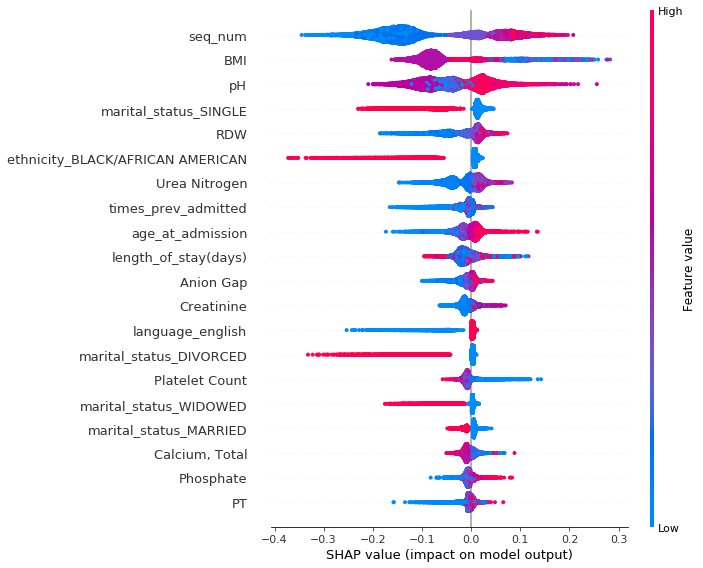

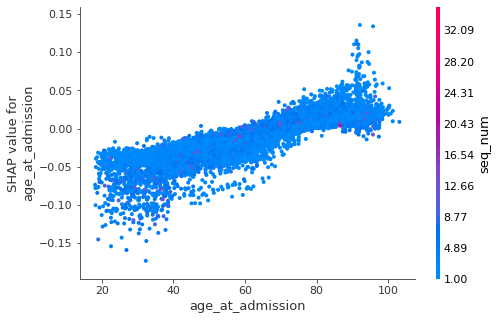

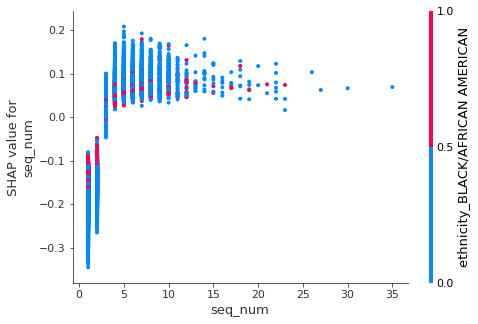

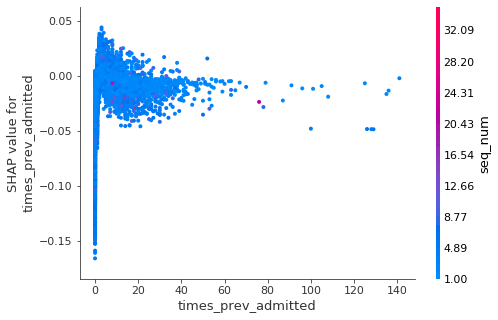

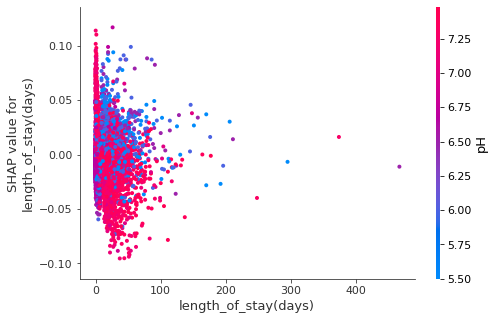

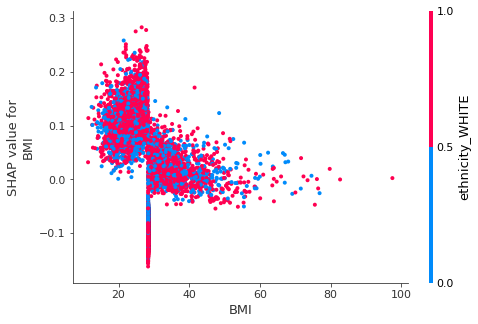

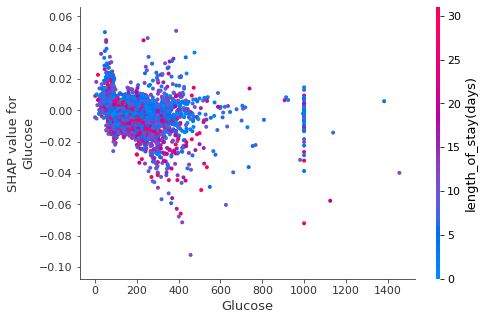

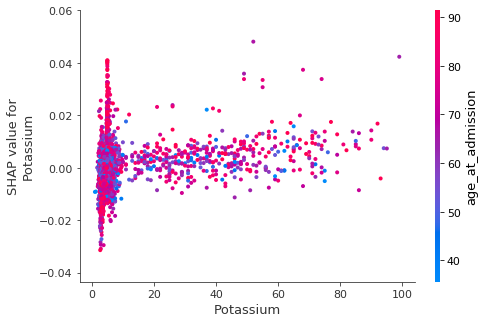

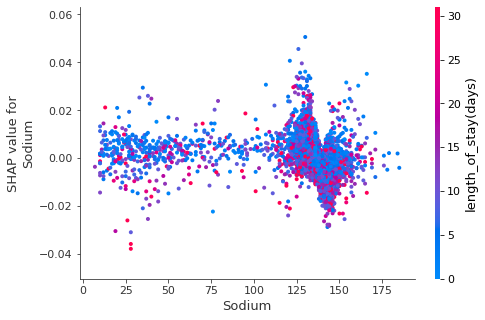

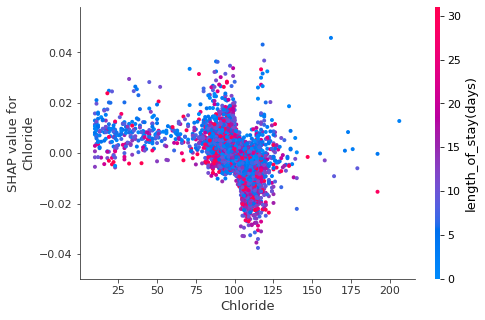

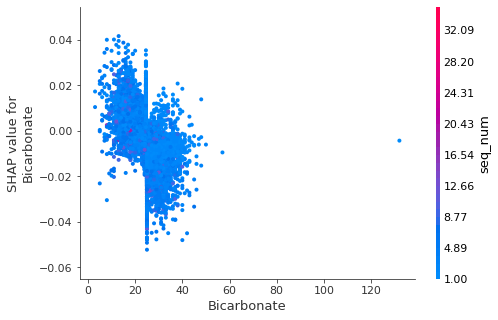

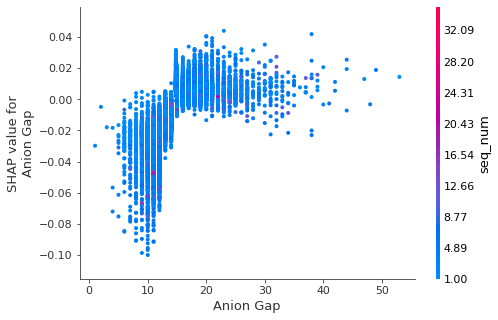

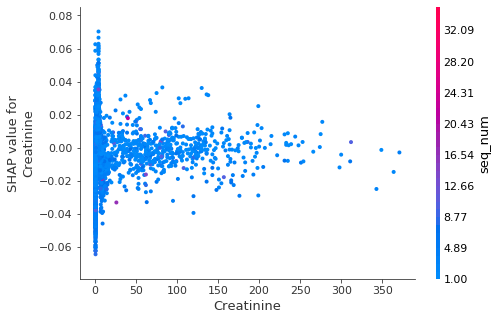

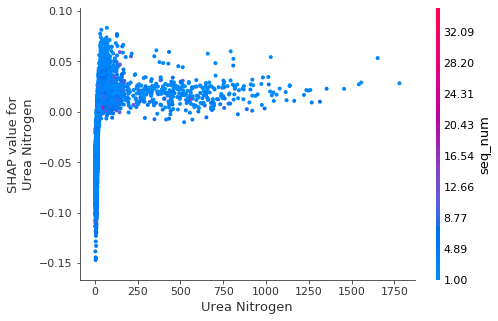

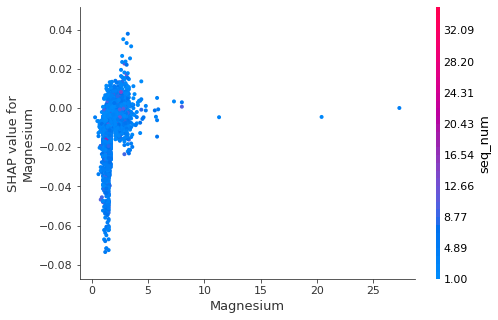

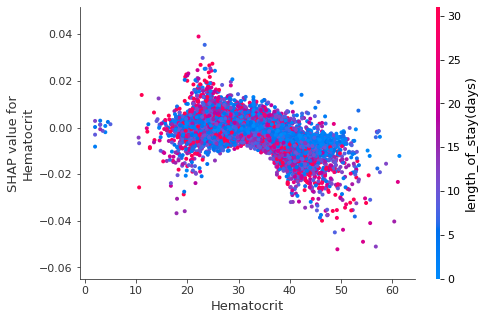

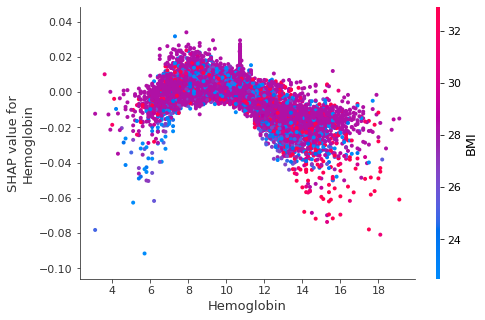

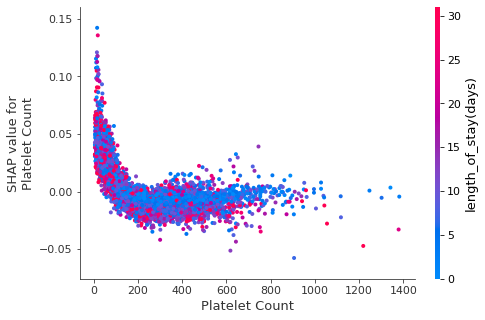

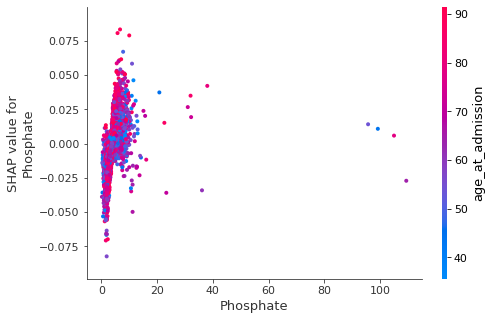

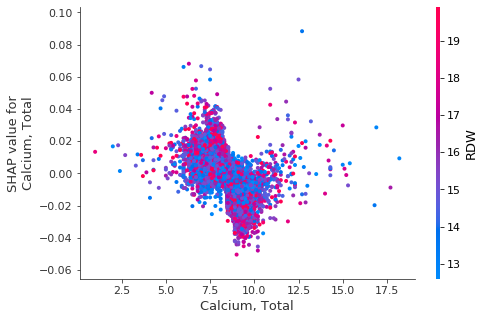

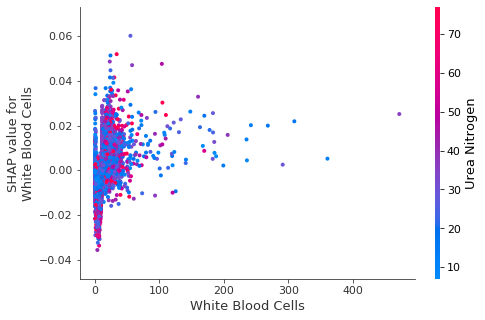

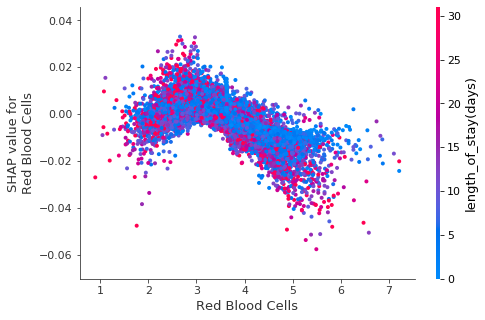

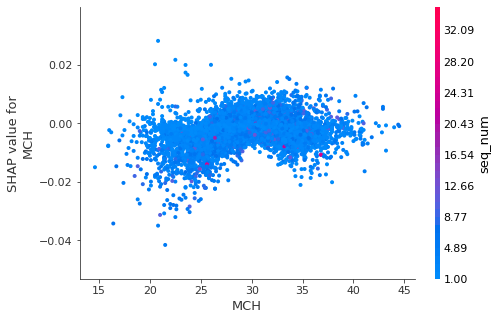

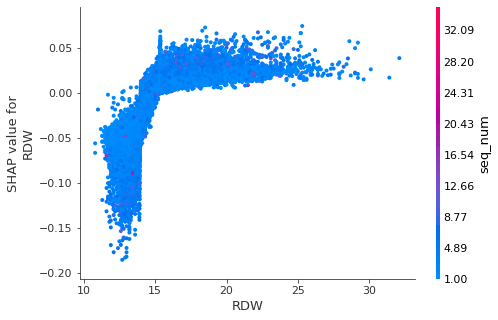

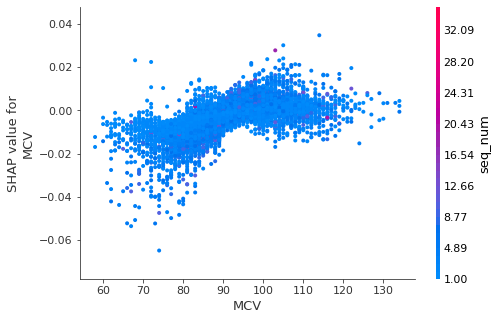

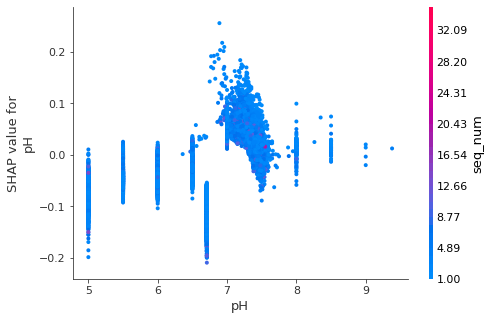

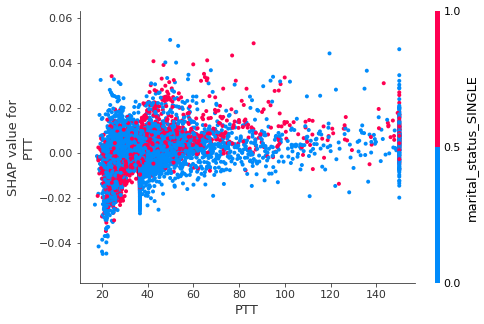

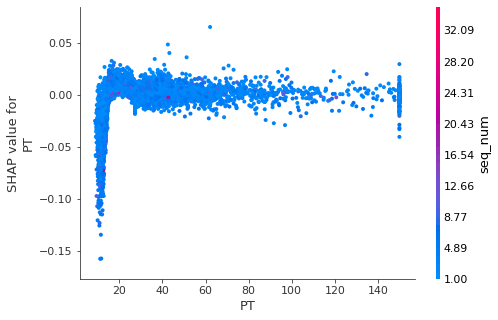

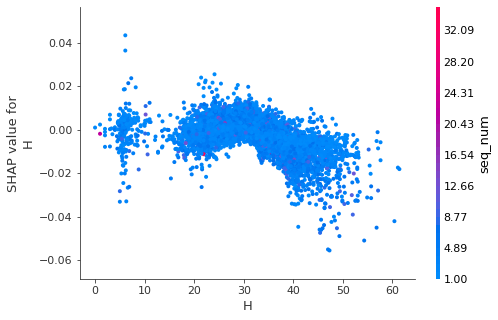

In [6]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values[1],X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1],X_no_cat ,feature_names=feature_names)

## XGBOOST

In [7]:
xgb_classifier = xgb.XGBClassifier(objective = "binary:logistic",random_state=rand_state)
xgb_params = { 
        'xgbclassifier__learning_rate': (0.01, 0.05,0.1),
        'xgbclassifier__min_child_weight': [3, 5, 10],
        'xgbclassifier__gamma': [0.5, 1.5, 2, 5],
        'xgbclassifier__subsample': [0.6, 0.8, 1.0],
        'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
        'xgbclassifier__max_depth': list(range(5,30)),
        'xgbclassifier__scale_pos_weight': [0.5,0.75,0.9,1, 1.1, 1.25,1.5]
}
model = strat_cv_it(xgb_classifier ,xgb_params,False,50)['xgbclassifier']
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  9.2min finished


0.8486037145438067

{'xgbclassifier__subsample': 0.6,
 'xgbclassifier__scale_pos_weight': 0.75,
 'xgbclassifier__min_child_weight': 5,
 'xgbclassifier__max_depth': 20,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__gamma': 5,
 'xgbclassifier__colsample_bytree': 0.8}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       22.570235      0.387438         0.080910        0.001402   
1        7.152566      0.101391         0.042886        0.001628   
2       15.380152      0.090531         0.122104        0.007718   
3       14.122740      0.031752         0.060440        0.001857   
4       20.110655      0.079578         0.081320        0.002273   
5       19.900636      0.060807         0.091943        0.009857   
6       10.422874      0.073783         0.082509        0.004746   
7       22.893707      0.115482         0.086108        0.001687   
8       14.880981      0.086981         0.094999        0.001849   
9       15.364130      0.044907         0.079500        0.000984   
10      15.850100      0.148979         0.066864        0.000384   
11      18.567928      0.079910         0.104395        0.002262   
12      21.932732      0.115721         0.093592        0.001935   
13       9.235826      0.066662         0.046548        0.002869   
14      10.076112      0.028386         0.056891        0.000427   
15      11.575632      0.073661         0.067219        0.001255   
16       7.820802      0.008417         0.054025        0.001544   
17      15.047548      0.047700         0.115071        0.002578   
18      21.276532      0.322040         0.075343        0.003665   
19      13.715879      0.100961         0.100964        0.002133   
20      14.056687      0.035547         0.114868        0.001036   
21       9.132417      0.044635         0.036590        0.002021   
22      21.113725      0.138727         0.073470        0.003291   
23       9.339702      0.263068         0.062167        0.002860   
24      12.223434      0.097458         0.060122        0.000342   
25      16.059500      0.093629         0.085630        0.003067   
26      12.955223      0.073447         0.079180        0.003315   
27       8.049248      0.093205         0.060091        0.002659   
28      16.971221      0.416520         0.103456        0.005322   
29      16.026468      0.522101         0.066821        0.000814   
30      15.323116      0.320262         0.104055        0.008707   
31       8.478984      0.065856         0.036902        0.005086   
32      17.345445      0.351194         0.098905        0.006490   
33      17.921154      0.209935         0.135190        0.021428   
34      10.762168      0.515292         0.070856        0.007003   
35      11.280238      0.049677         0.071531        0.004964   
36      16.671785      0.123827         0.079173        0.001295   
37      14.606728      0.132524         0.069179        0.000840   
38      11.231094      0.067735         0.087939        0.001164   
39      15.818767      0.098637         0.114699        0.002150   
40       8.179385      0.034689         0.046563        0.003113   
41      14.025187      0.055072         0.076547        0.001432   
42      10.520492      0.098742         0.072503        0.003693   
43      11.543351      0.056768         0.087608        0.000631   
44      12.917544      0.073567         0.083681        0.001885   
45      19.316727      0.072035         0.093149        0.002437   
46      16.326754      0.092667         0.088088        0.001612   
47      11.090970      0.009212         0.076702        0.001220   
48      13.614400      0.055010         0.067012        0.001327   
49      12.771111      0.066411         0.078795        0.012922   

   param_xgbclassifier__subsample param_xgbclassifier__scale_pos_weight  \
0                             0.8                                  1.25   
1                             0.6                                  0.75   
2                               1                                   1.5   
3                             0.8                                   0.5   
4                             0.8                                  1.25   
5                               1                                   0.5   
6         

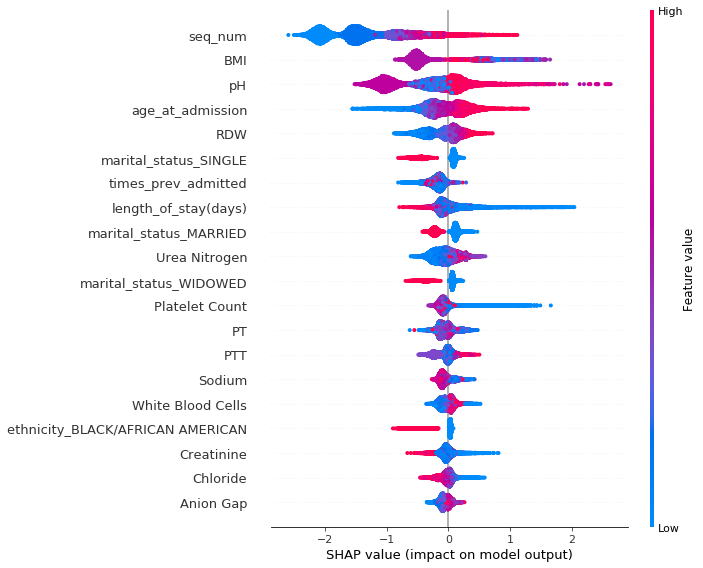

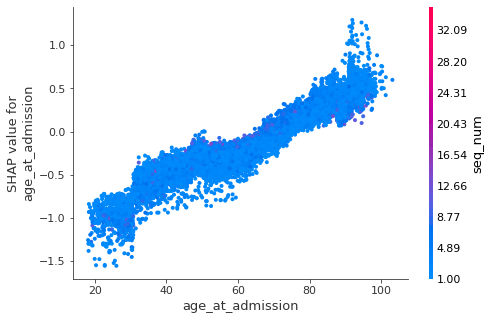

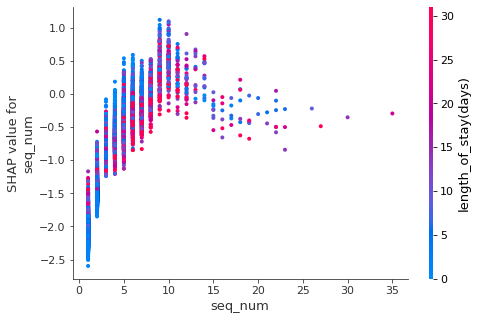

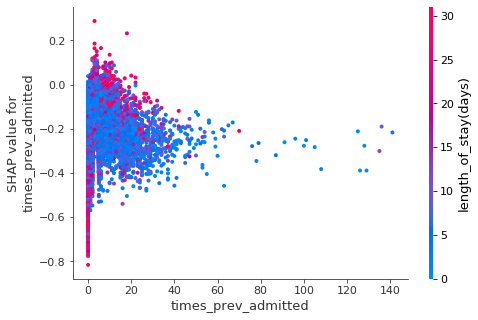

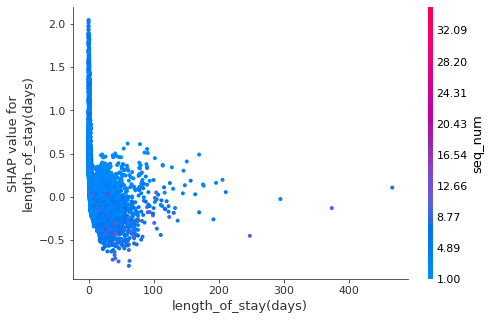

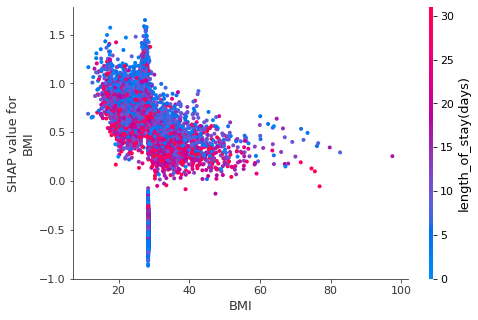

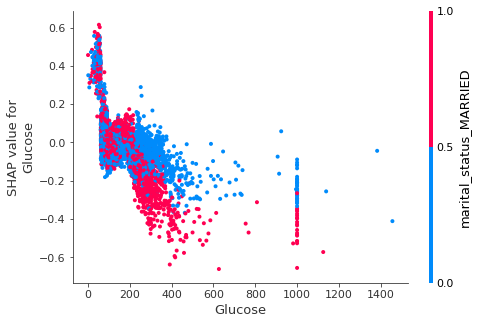

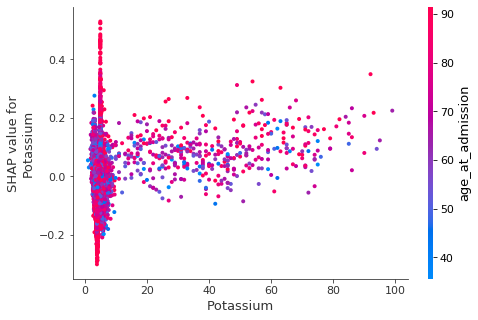

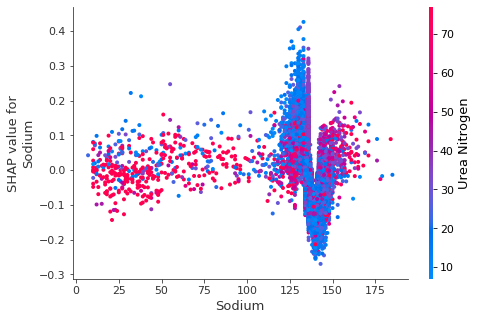

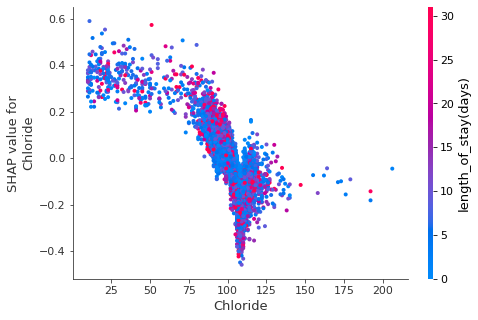

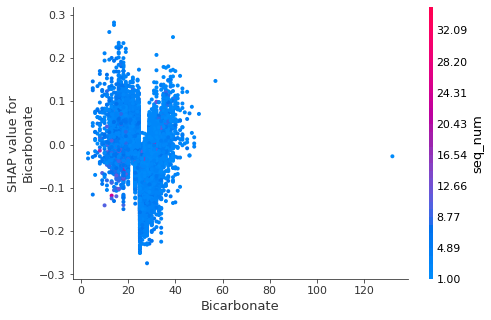

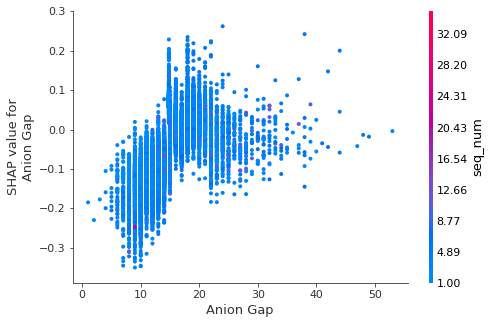

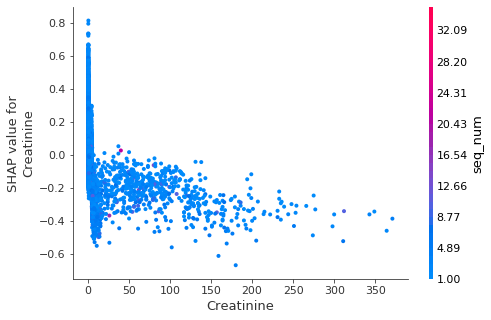

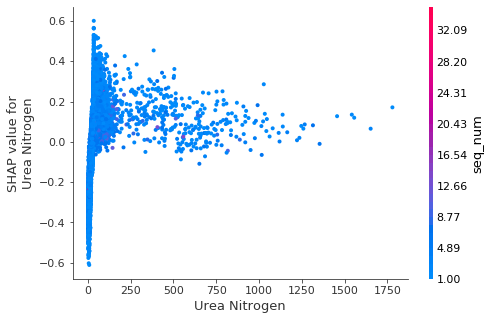

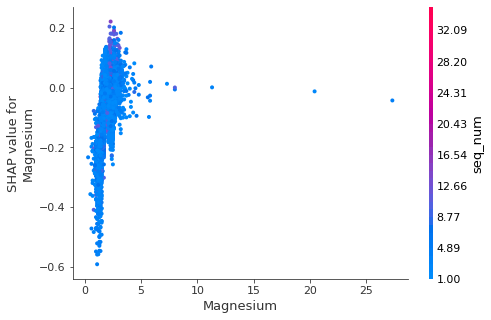

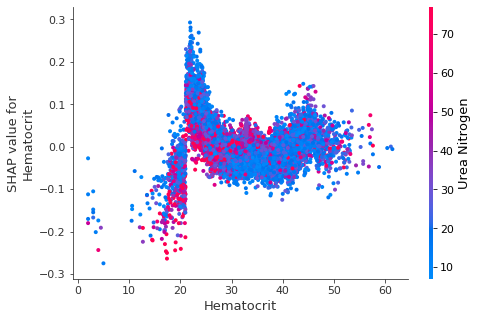

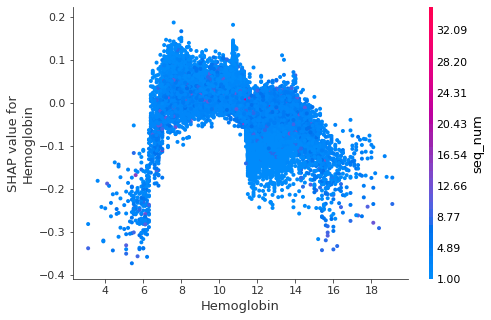

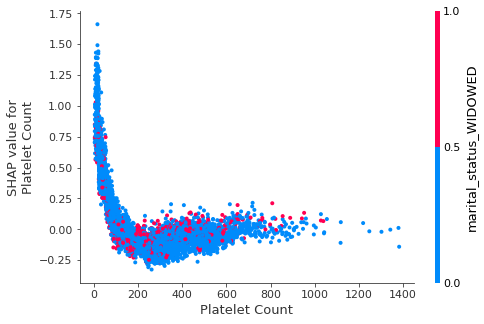

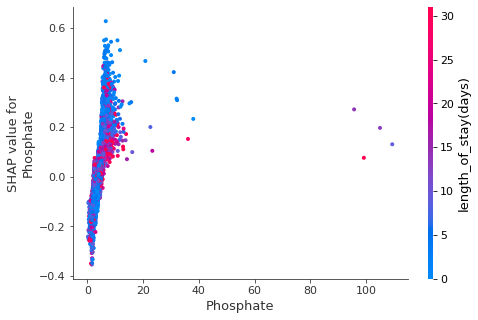

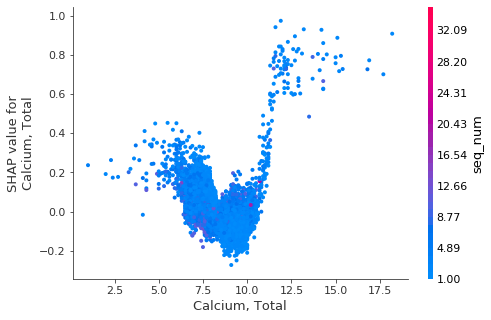

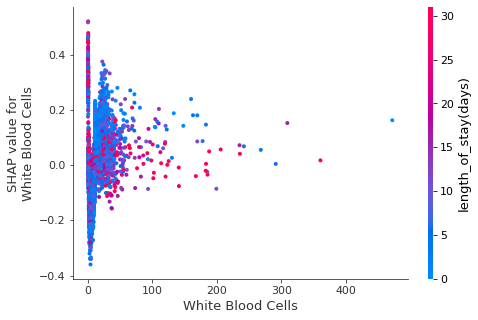

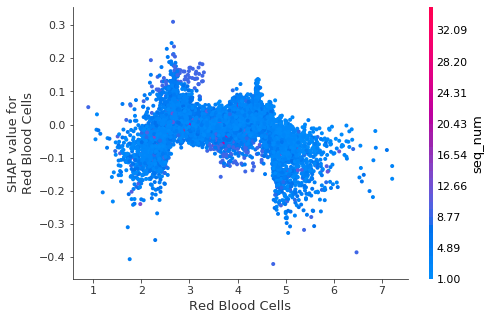

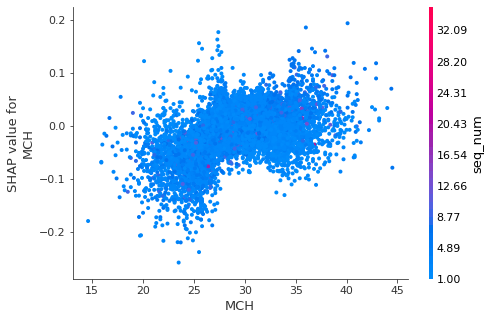

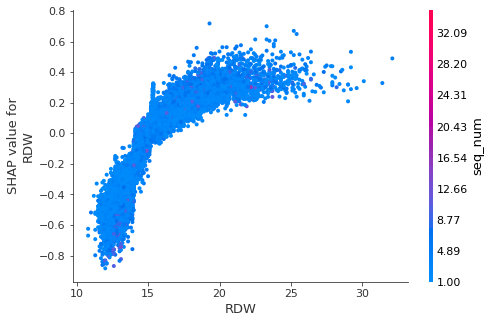

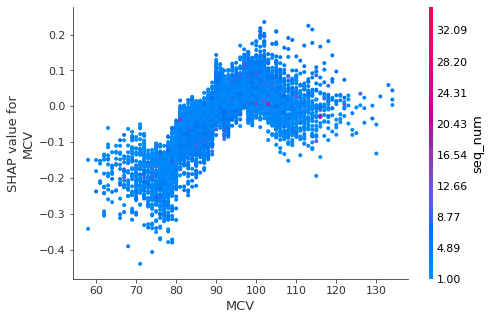

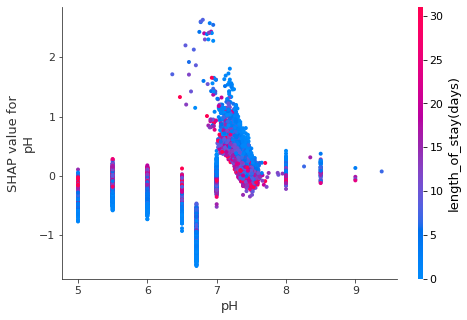

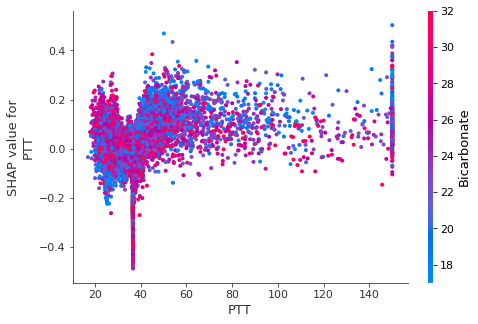

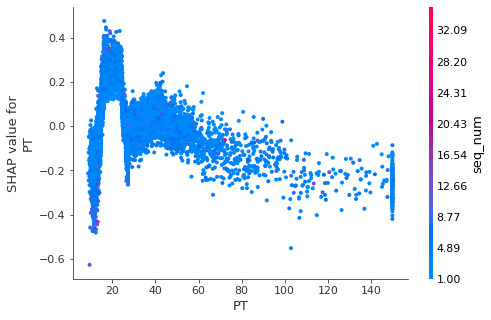

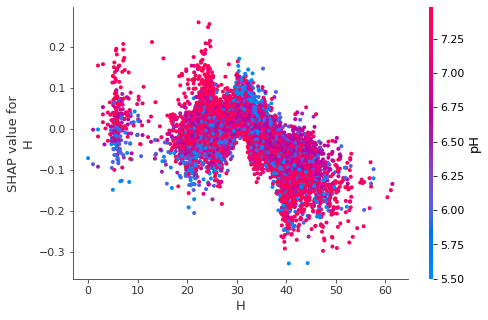

In [8]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values,X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values,X_no_cat ,feature_names=feature_names)

# CatBoost

In [9]:
CB_classifier = CatBoostClassifier(
     verbose=False,
     early_stopping_rounds=50,
)
CB_params = {
        'catboostclassifier__learning_rate': [0.05, 0.1],
        'catboostclassifier__depth': [4,5,6,7,8,9],
        'catboostclassifier__l2_leaf_reg': [1, 3, 5, 7, 8],
        'catboostclassifier__scale_pos_weight': [0.5,0.75,0.9,1, 1.1, 1.25,1.5]

} 
# Note Attention: (ignore, affects speed(not result quality))
# Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.
# Note that using SMOTENC doesn't work with catboost as it requires int and it by default converts to int
model = strat_cv_it(CB_classifier ,CB_params,True,25)['catboostclassifier']
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 26.7min finished


0.8493891380680071

{'catboostclassifier__scale_pos_weight': 0.5,
 'catboostclassifier__learning_rate': 0.05,
 'catboostclassifier__l2_leaf_reg': 8,
 'catboostclassifier__depth': 6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       50.400734      3.341795         0.614677        0.142354   
1      112.441602      2.464481         0.575656        0.041244   
2       57.546369      3.092308         0.727616        0.076874   
3      186.054109      1.159778         0.747724        0.204461   
4      173.714625      5.439428         0.735101        0.202348   
5       51.526992      0.821184         0.769850        0.080290   
6       52.178947      0.373745         0.635010        0.318410   
7       43.874085      1.387668         0.618380        0.167557   
8       40.696043      2.670948         0.681914        0.239229   
9       46.010718      1.335660         0.650310        0.209332   
10      47.484333      0.598652         0.561394        0.183003   
11      47.843522      0.629161         0.731562        0.220569   
12     180.780909      1.453931         0.823313        0.140079   
13      56.318288      1.136717         0.755994        0.256828   
14     113.506899      1.005744         0.843389        0.024269   
15     173.332204      1.348522         0.864261        0.100492   
16      47.387995      0.982534         0.825911        0.240968   
17      80.188179      2.412972         0.675454        0.138766   
18      57.771235      0.415034         0.607044        0.010264   
19      77.358226      0.984173         0.636839        0.108520   
20      59.264793      1.966665         0.660435        0.159032   
21      77.938378      2.878573         0.771055        0.075160   
22     113.357248      3.381001         0.844783        0.180976   
23      75.696005      5.653533         0.517148        0.254669   
24      36.925605     12.290815         0.450533        0.202139   

   param_catboostclassifier__scale_pos_weight  \
0                                        1.25   
1                                        1.25   
2                                         0.5   
3                                        1.25   
4                                           1   
5                                           1   
6                                         1.5   
7                                         1.1   
8                                         0.9   
9                                         0.9   
10                                        0.5   
11                                          1   
12                                        1.1   
13                                        1.5   
14                                        1.1   
15                                        1.5   
16                                        0.9   
17                                        0.9   
18                                        0.5   
19                                        0.5   
20                                          1   
21                                       0.75   
22                                        1.1   
23                                        1.1   
24                                        1.5   

   param_catboostclassifier__learning_rate  \
0                                     0.05   
1                                      0.1   
2                                      0.1   
3                                     0.05   
4                                      0.1   
5                                     0.05   
6                                     0.05   
7                                      0.1   
8                                     0.05   
9                                     0.05   
10                                    0.05   
11                                     0.1   
12                                    0.05   
13                                    0.05   
14                                    0.05   
15                                    0.05   
16                                     0.1   
17                                     0.1   
18                                    0.05   
19                                     0

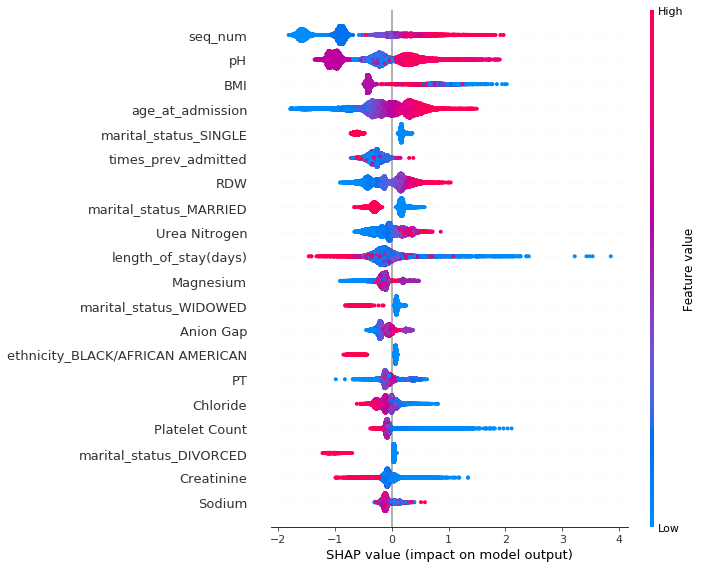

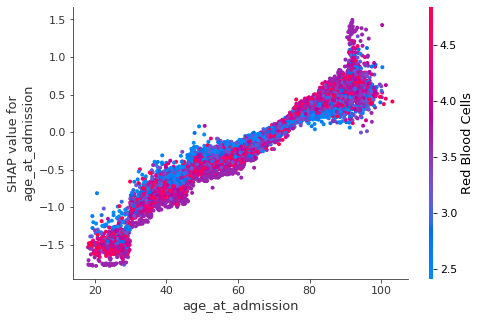

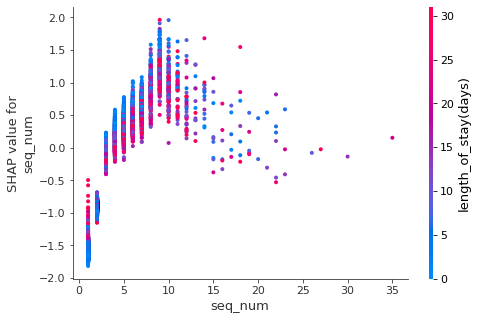

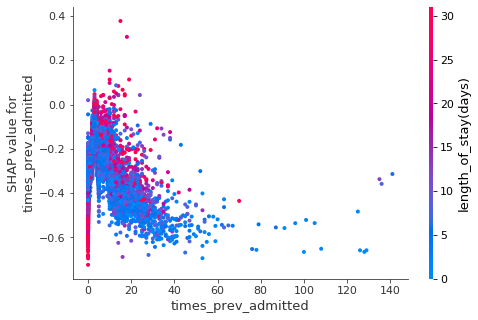

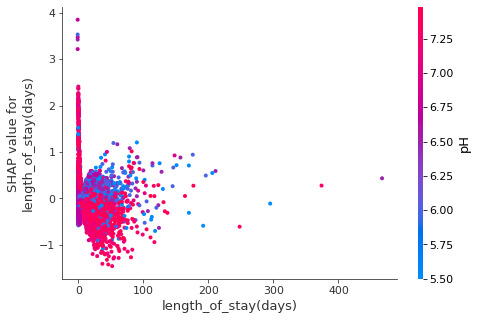

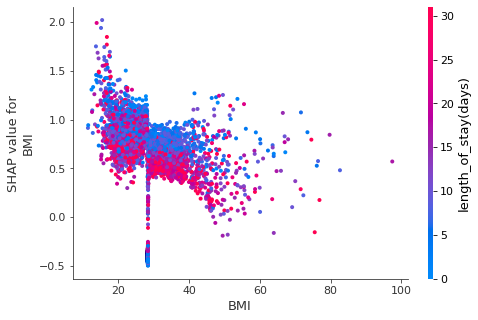

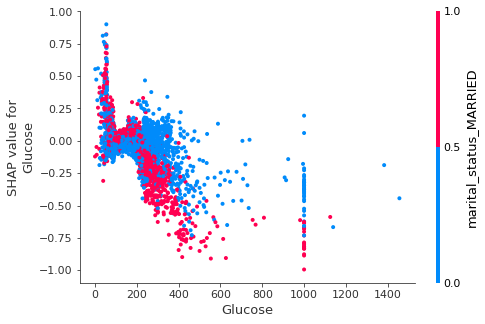

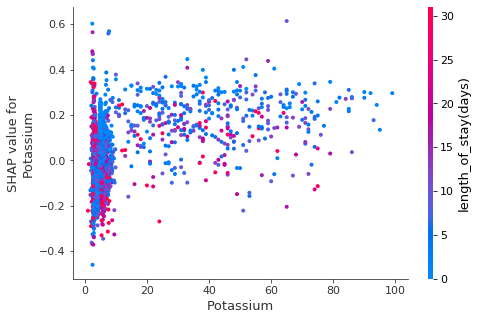

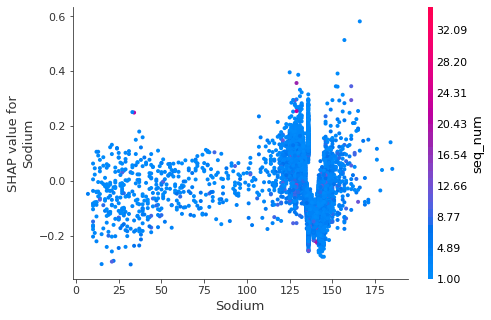

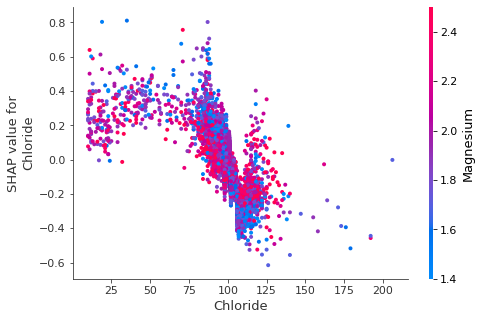

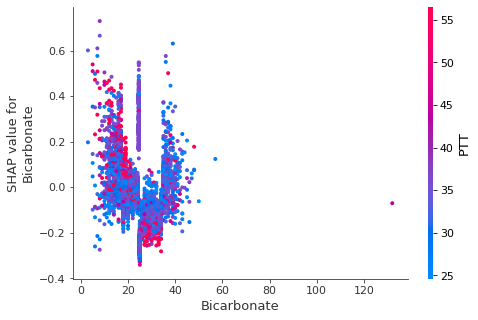

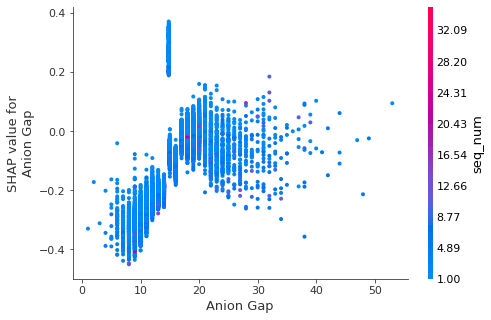

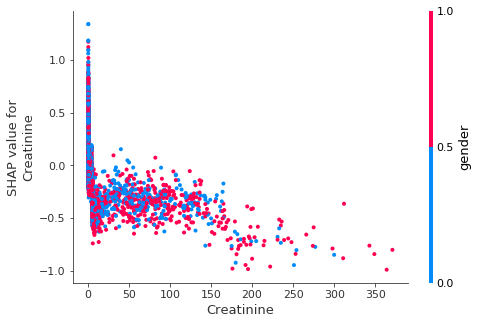

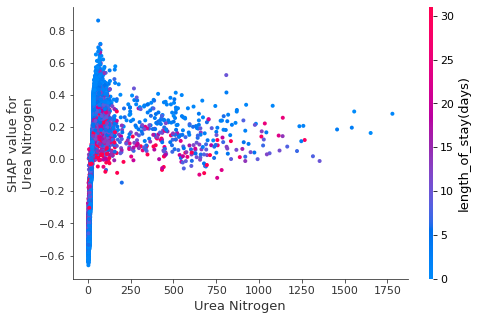

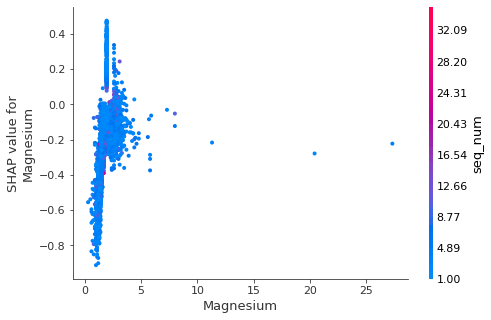

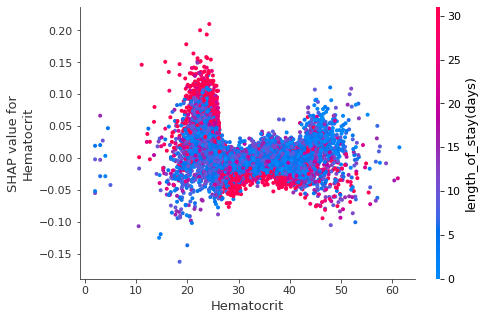

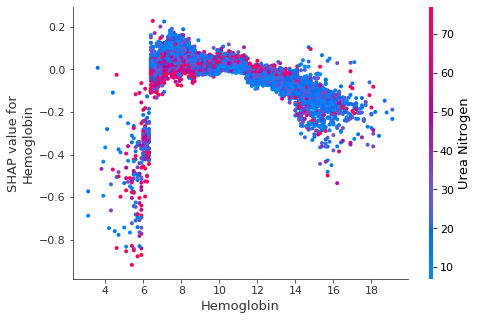

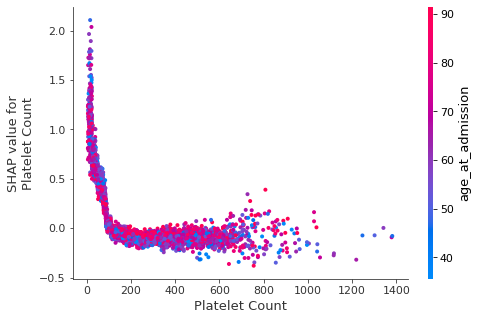

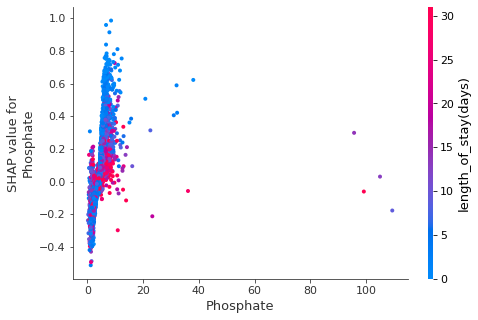

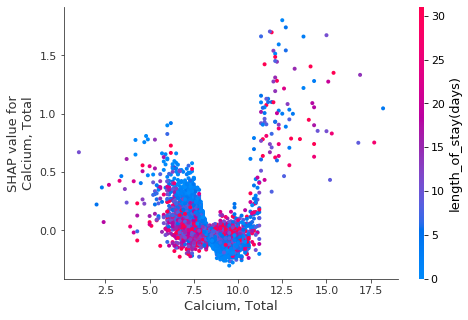

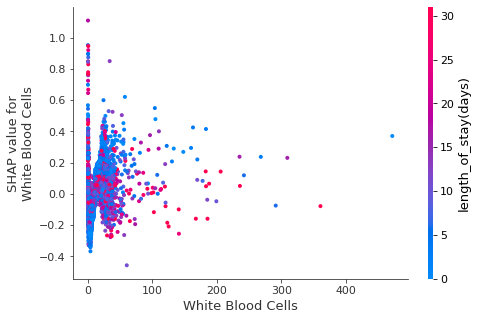

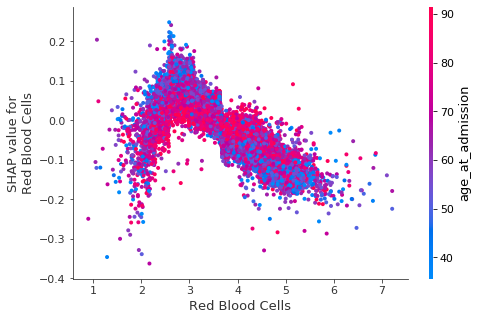

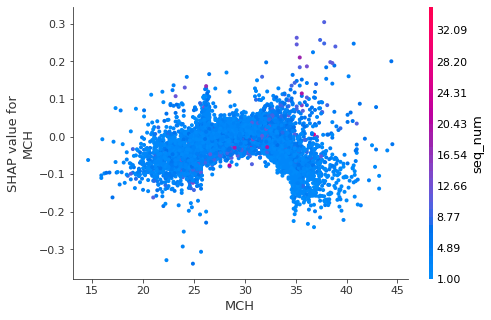

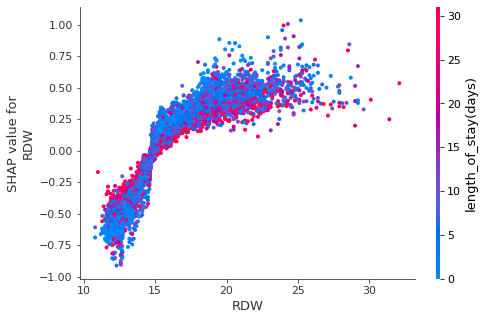

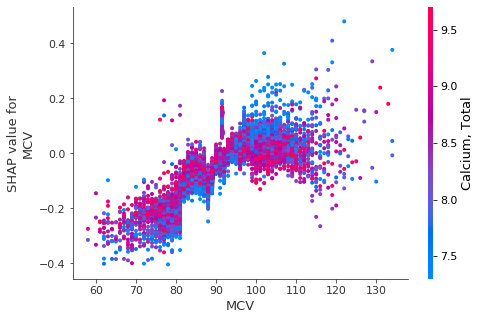

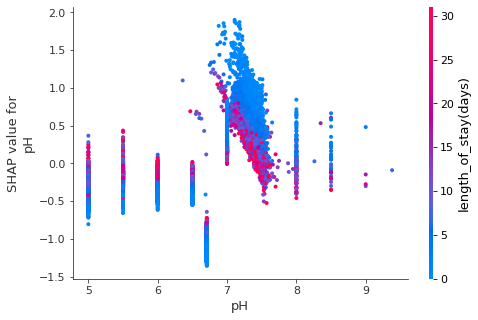

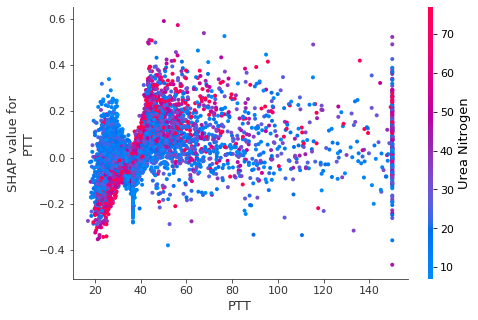

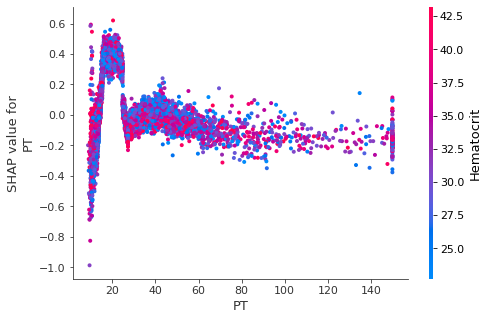

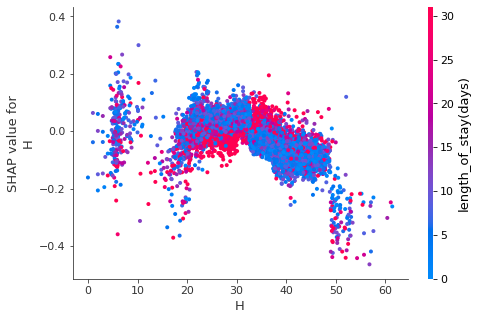

In [10]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values, dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values ,dataset_no_target ,feature_names=feature_names)

# LightGBM

In [11]:
LGB_classifier = lgb.LGBMClassifier()
LGB_params = {
             'lgbmclassifier__num_leaves': [1,5,8,10,15,20,35,40], 
             'lgbmclassifier__min_child_samples': [1,5,10,20,50,100,200,300,400,500], 
             'lgbmclassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'lgbmclassifier__subsample': [0.2,0,4,0.5, 0.6, 0.8, 1.0],
             'lgbmclassifier__colsample_bytree': [0.6, 0.8, 1.0],
             'lgbmclassifier__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'lgbmclassifier__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'lgbmclassifier__scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]

}
model = strat_cv_it(LGB_classifier ,LGB_params,True,50)['lgbmclassifier']
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   37.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.6min finished


0.8496759412133139

{'lgbmclassifier__subsample': 0.6,
 'lgbmclassifier__scale_pos_weight': 1.5,
 'lgbmclassifier__reg_lambda': 0,
 'lgbmclassifier__reg_alpha': 0,
 'lgbmclassifier__num_leaves': 20,
 'lgbmclassifier__min_child_weight': 0.001,
 'lgbmclassifier__min_child_samples': 200,
 'lgbmclassifier__colsample_bytree': 0.6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.758797      0.070851         0.065867        0.002980   
1        4.207443      0.076923         0.091783        0.008295   
2        4.449619      0.057903         0.094459        0.012246   
3        3.295873      0.110332         0.000000        0.000000   
4        3.778767      0.038120         0.090757        0.003549   
5        3.480570      0.045544         0.034258        0.004004   
6        3.964361      0.066791         0.085019        0.007750   
7        3.264692      0.080569         0.000000        0.000000   
8        3.572208      0.014610         0.059224        0.004515   
9        3.866475      0.043226         0.072974        0.002652   
10       3.959478      0.047737         0.087185        0.002676   
11       3.203869      0.052000         0.000000        0.000000   
12       3.090769      0.005954         0.000000        0.000000   
13       3.416896      0.049043         0.034906        0.004954   
14       3.170081      0.052617         0.000000        0.000000   
15       3.181633      0.005420         0.000000        0.000000   
16       3.109535      0.010765         0.000000        0.000000   
17       3.858851      0.020631         0.075364        0.004580   
18       3.190323      0.068402         0.000000        0.000000   
19       3.650920      0.035845         0.058547        0.006556   
20       3.850887      0.037066         0.070870        0.004315   
21       3.795853      0.057856         0.074269        0.004805   
22       3.531902      0.044115         0.033601        0.002054   
23       3.522239      0.013971         0.038564        0.007992   
24       3.636221      0.026222         0.059193        0.003279   
25       3.926702      0.026717         0.072994        0.003786   
26       3.211349      0.046613         0.000000        0.000000   
27       3.128099      0.041357         0.000000        0.000000   
28       4.115102      0.089239         0.086222        0.003914   
29       3.207240      0.075295         0.000000        0.000000   
30       3.125043      0.046966         0.000000        0.000000   
31       3.978353      0.068555         0.074353        0.003990   
32       3.217037      0.062113         0.000000        0.000000   
33       4.449612      0.049587         0.110965        0.011412   
34       3.270129      0.077271         0.000000        0.000000   
35       3.131607      0.034752         0.000000        0.000000   
36       3.163146      0.016659         0.000000        0.000000   
37       3.694850      0.026299         0.072965        0.003598   
38       3.972989      0.038637         0.070183        0.001933   
39       3.177661      0.045801         0.000000        0.000000   
40       4.029796      0.050316         0.079016        0.003043   
41       3.325439      0.068075         0.000000        0.000000   
42       3.884497      0.055679         0.068826        0.000802   
43       4.154581      0.068939         0.099789        0.003218   
44       3.908096      0.048685         0.074474        0.003757   
45       3.170589      0.031651         0.000000        0.000000   
46       3.108413      0.040847         0.000000        0.000000   
47       3.912890      0.050714         0.088098        0.006829   
48       3.233368      0.070584         0.000000        0.000000   
49       3.777991      0.043656         0.103745        0.001402   

   param_lgbmclassifier__subsample param_lgbmclassifier__scale_pos_weight  \
0                              0.2                                    0.5   
1                              0.8                                    0.5   
2                                1                                      1   
3                                1                                    0.9   
4                              0.5                                   1.25   
5                                1                                    0.9

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


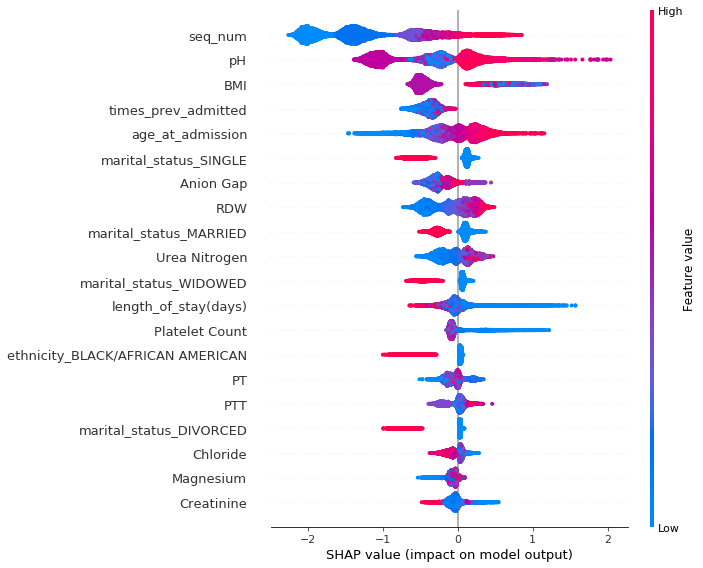

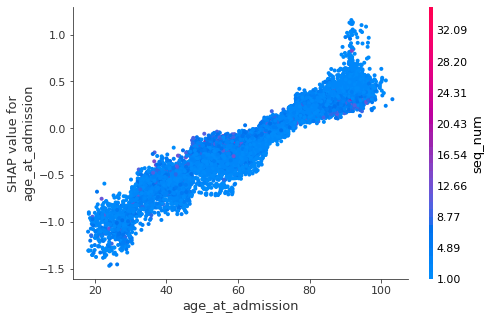

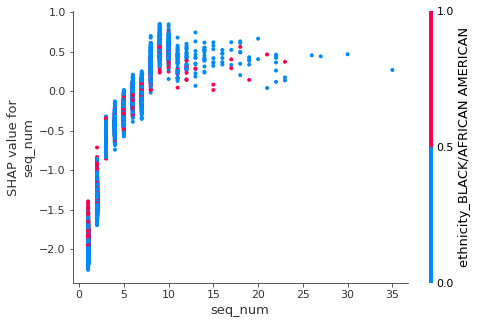

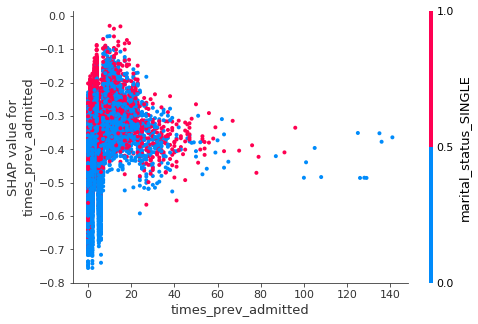

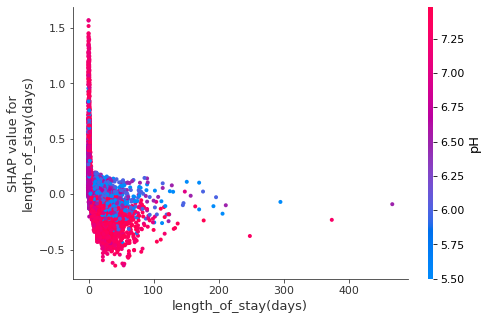

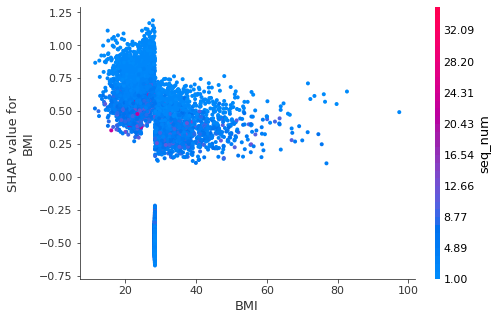

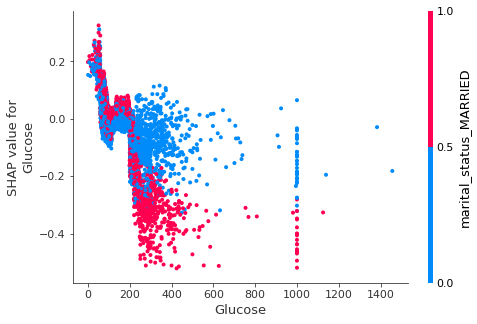

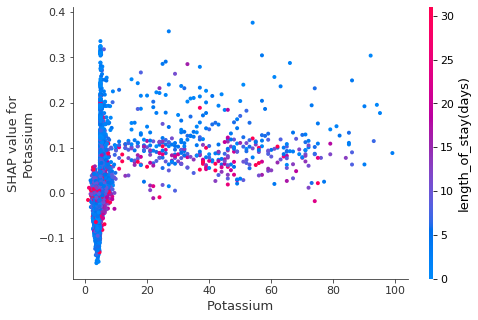

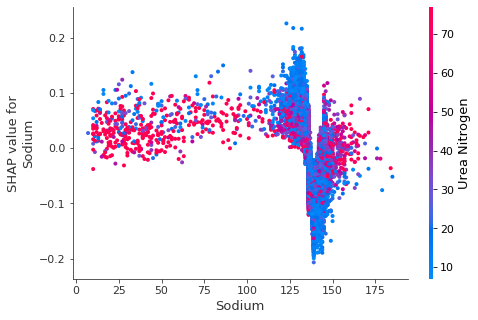

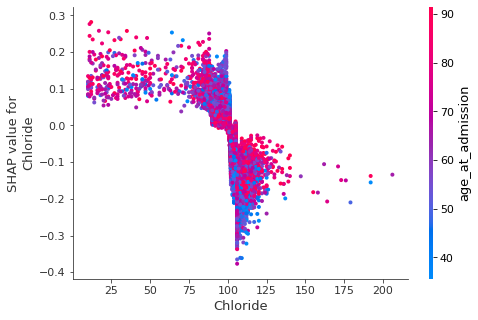

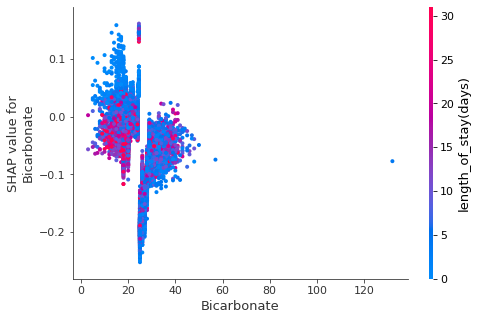

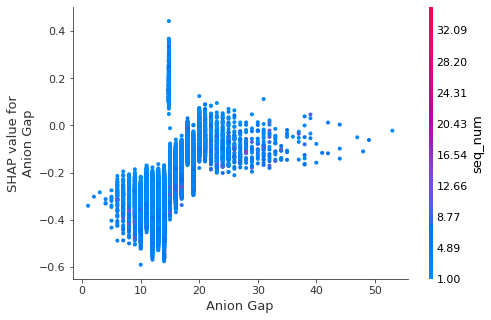

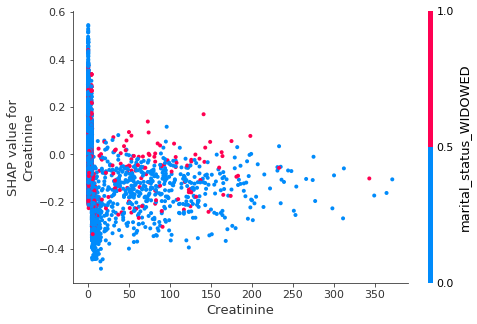

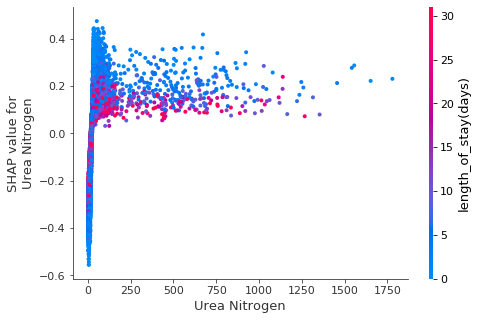

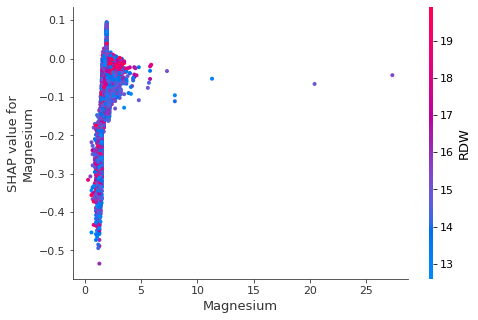

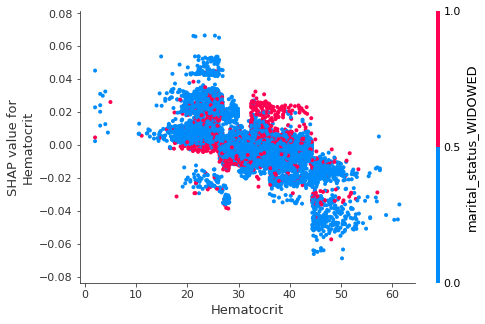

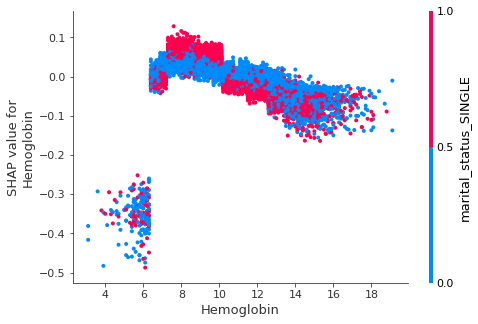

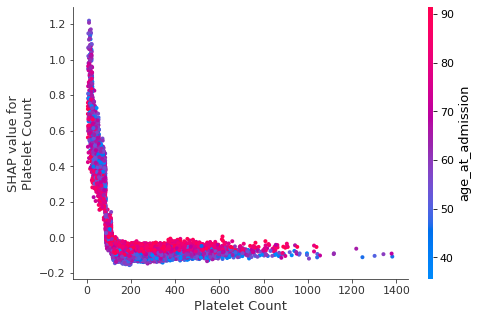

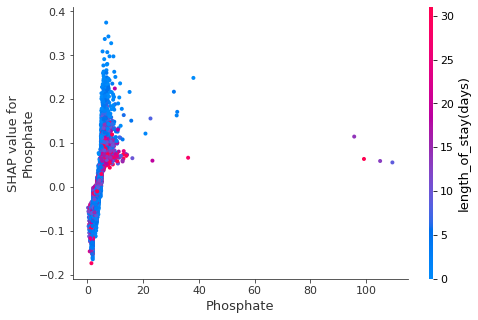

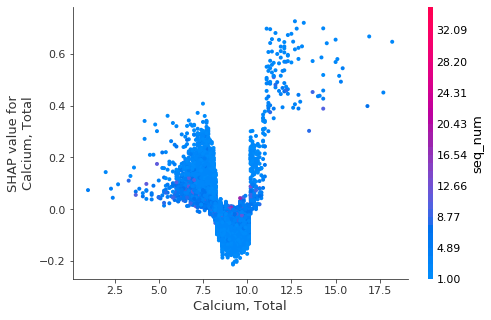

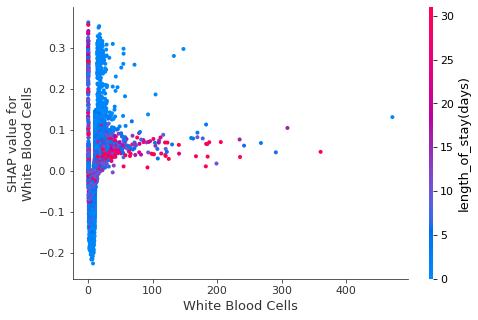

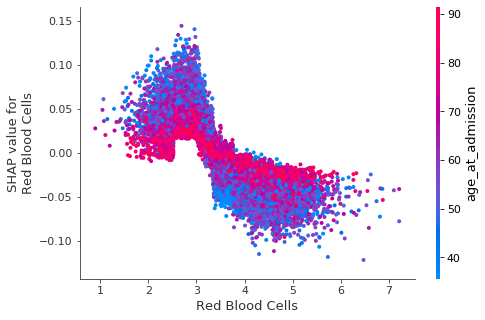

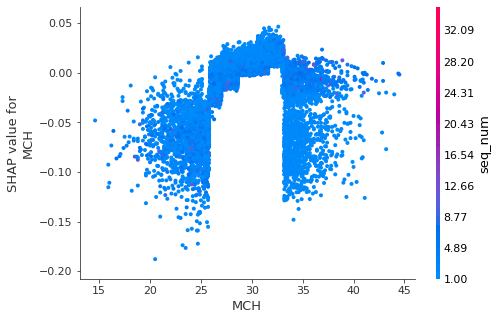

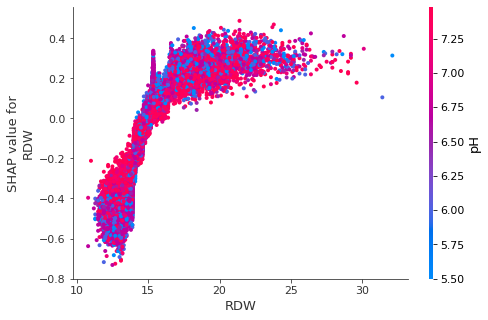

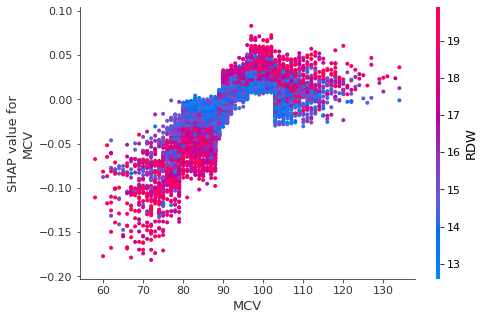

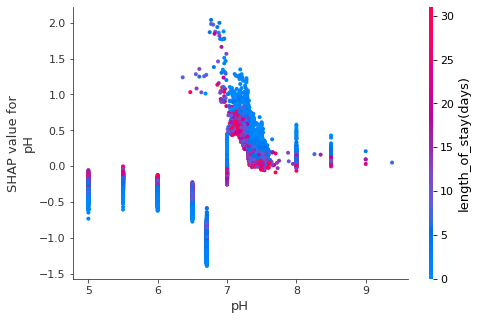

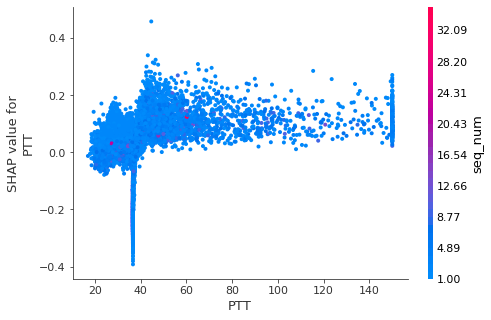

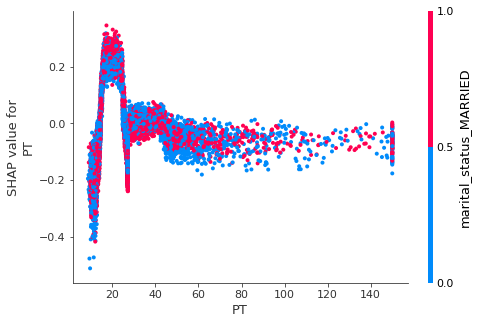

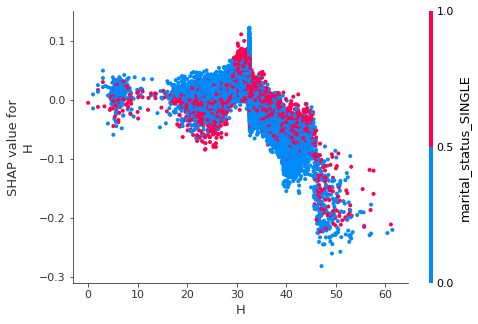

In [12]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values[1], dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1] ,dataset_no_target ,feature_names=feature_names)